In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *
import matplotlib
import warnings
import seaborn as sns

### load predicted behaviors

In [2]:
behaviors = load_behaviors('../processed_dataset/behaviors_sni_combined.pkl')

In [3]:
def get_duration_bouts(predict, behavior_classes, framerate=60):
    behav_durations = []
    bout_start_idx = np.where(np.diff(np.hstack([-1, predict])) != 0)[0]
    bout_durations = np.hstack([np.diff(bout_start_idx), len(predict) - np.max(bout_start_idx)])
    bout_start_label = predict[bout_start_idx]
    for b, behavior_name in enumerate(behavior_classes):
        idx_b = np.where(bout_start_label == int(b))[0]
        if len(idx_b) > 0:
            behav_durations.append(bout_durations[idx_b]/framerate)
        else:
            a = np.empty((1,))
            a[:] = np.nan
            behav_durations.append(a)
    return behav_durations

### plot -- Group (row) x Condition (column)

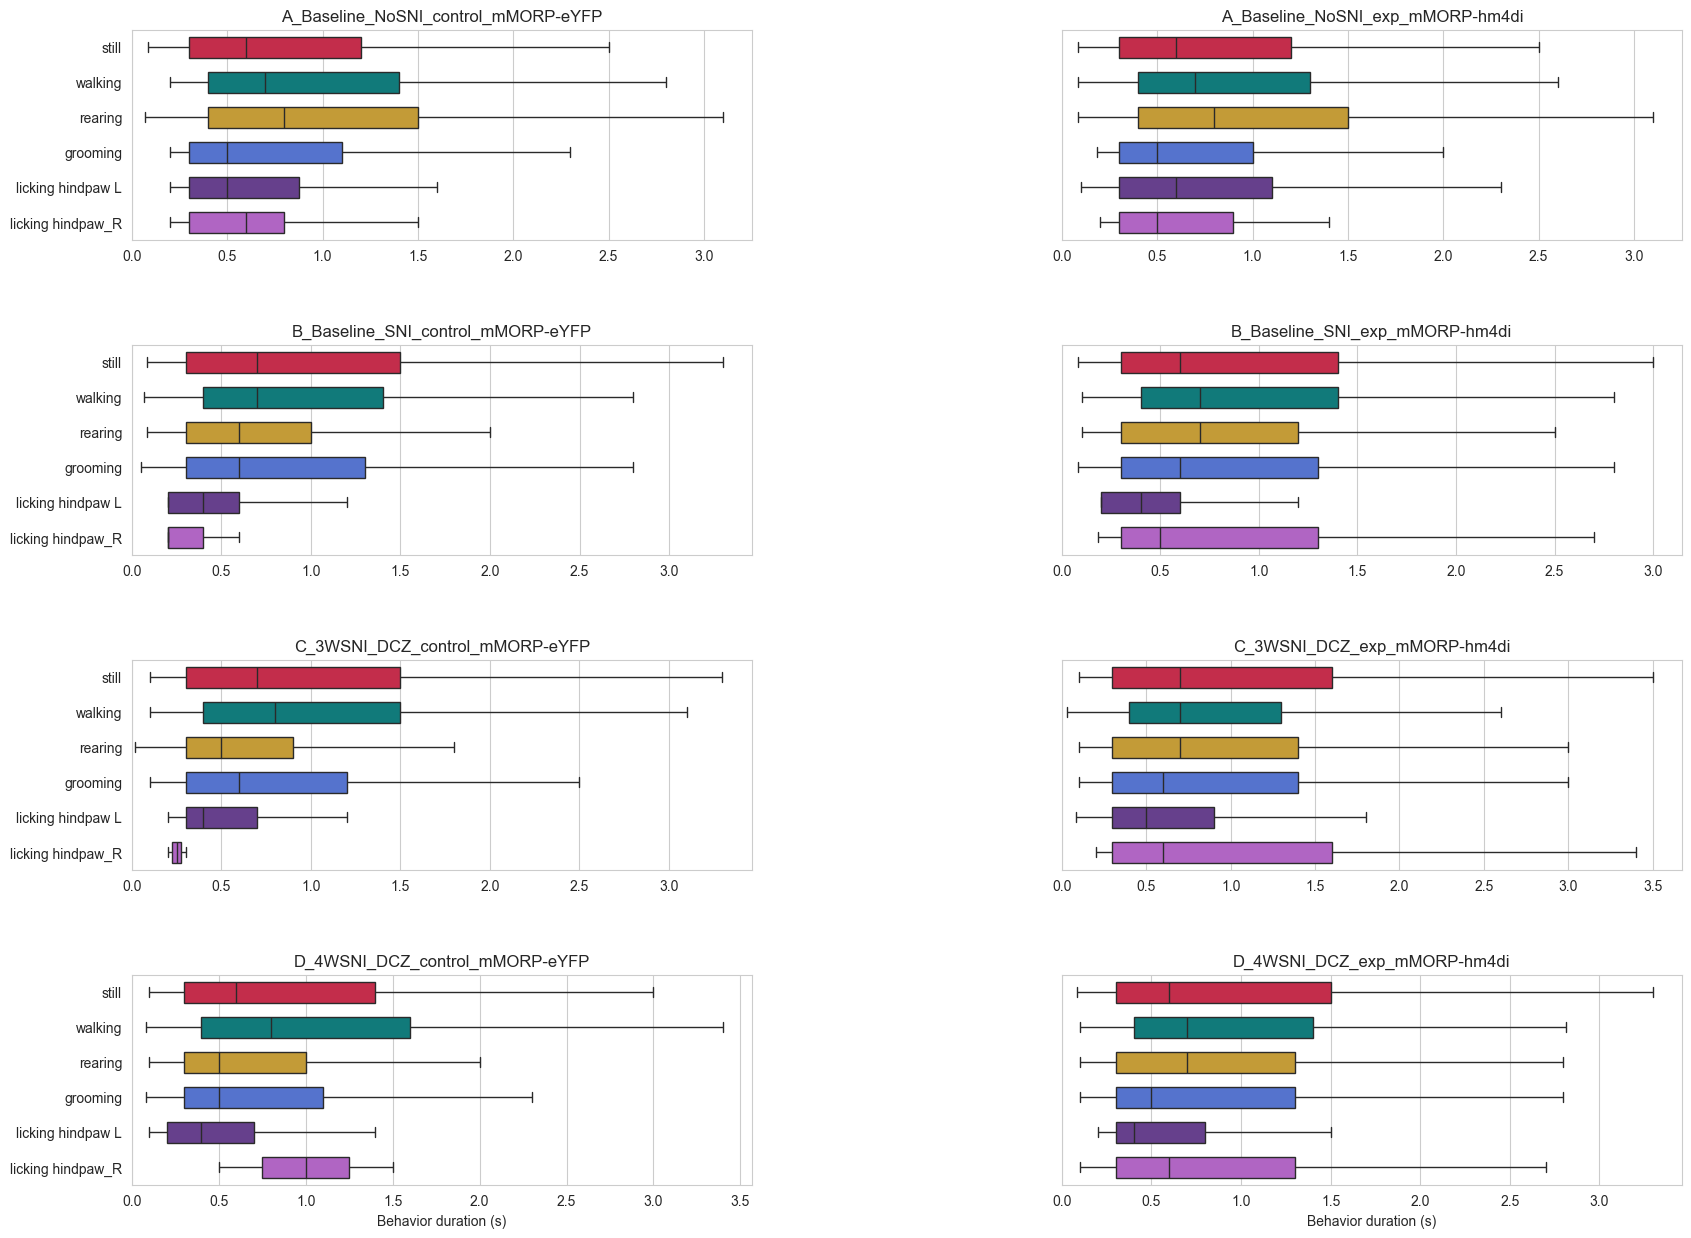

In [4]:
rows = len(groups_sni_combined)
cols = len(conditions_sni_combined)
count = 0
fig, ax = plt.subplots(rows, cols, figsize=(20, 15), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for row in range(rows):
    if row > 4:
        cols = 1
        fig.delaxes(ax[row, 1])
        fig.delaxes(ax[row, 2])
    else:
        cols = len(conditions_sni_combined)
        
    for col in range(cols):
        
        selected_group = groups_sni_combined[row]
        selected_condition = conditions_sni_combined[col]
        
        durations_ = []
        for f in range(len(behaviors[selected_group][selected_condition])):
            durations_.append(get_duration_bouts(behaviors[selected_group][selected_condition][f'file{f}'], behavior_names))
        durations_dict = {'behavior': np.hstack([np.hstack([np.repeat(behavior_names[i],
                                                           len(durations_[f][i])) 
                                                 for i in range(len(durations_[f]))]) for f in range(len(durations_))]),
                          'duration': np.hstack([np.hstack(durations_[f]) for f in range(len(durations_))]),
                          }
        durations_df = pd.DataFrame(durations_dict)
        durations_df.to_csv(f'../processed_dataset/behavior_instance_durations/behavior_durations_{groups_sni_combined[row]}_{conditions_sni_combined[col]}_oprm1-reexpress_morphine.csv')

        sns.boxplot(durations_df, x='duration', y='behavior', hue='behavior', 
                    orient='h', width=0.6,
                    palette=behavior_colors, showfliers=False, ax=ax[row, col])
        ax[row, col].set_ylabel('')
        ax[row, col].set_xlabel('')
        
        if col == 1 or col == 2:
            if row == rows-1:
                ax[row, col].set_xlabel('Behavior duration (s)')
        
                
        if row == rows-1:
            ax[row, col].set_xlabel('Behavior duration (s)')
        ax[row, col].set_title(f'{groups[row]}_{conditions[col]}')
        
        ax[row, col].set_aspect('auto', adjustable='box')
        
        ax[row, col].set_title(f'{groups_sni_combined[row]}_{conditions_sni_combined[col]}')
        ax[row, col].set_xlim(left=0)

plt.show()

### file save, change the extension to change the file format

In [5]:
fig.savefig(f'../figures/behavior_durations_sni_combined.svg', 
            dpi=600, bbox_inches='tight')